# В данном Jupyter Notebook проводится подготовка данных ChEMBL (29v) для обучающей выборки

Пайплайн:

1. Скачивание данных ChEMBL;
2. Удаление активностей по отношению к мутантным каналам hERG
3. Стандартизация единиц измерения активности к herg каналам
  - приведение к одним единицам измерения (nM)
  - пересчет в pIC50
4. Удаление дубликатов
5. Проверка на точность соотношений (=, >, <)
6. Чистка с помощью RDKit
7. Удаление солевых форм
8. Сохранение подготовленных данных в .sdf и .csv файлы

# Обработка данных с ChEMBL, traget = "CHEMBL240"

In [1]:
from pathlib import Path
import sys
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, MolStandardize
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
from IPython.display import display, display_png
from sklearn.preprocessing import FunctionTransformer
from pandas import DataFrame
import pandas as pd
import numpy as np
import logging

In [4]:
#! pip install chembl_webresource_client
from chembl_webresource_client.new_client import new_client

Подготовка данных для обучающей выборки

Посмотрим на все target, которые соответствуют поисковому запросу "herg"

In [6]:
#target = new_client.target
#target_query = target.search('herg')
#targets = pd.DataFrame.from_dict(target_query)
#targets

C помощью комманд в комментах ниже можно подгрузить данные, соответствубщие конкретной мишени. Однако загрузка может идти долго, поэтому воспользуемся уже скачанным таким образом файлом herg_in_web.csv 

In [7]:
#selected_target = 'CHEMBL240'

In [8]:
#selected_target = targets.target_chembl_id[0]
#activity = new_client.activity
#res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
#df = pd.DataFrame.from_dict(res)
#df

In [9]:
# df.to_csv("herg_in_web.csv", encoding='utf-8', index=False)

Т.е. опционально: можно загрузить все данные онлайн (выше),но иногда может тормозить. А можно загрузить сырой csv, который был скачан в последний раз:

In [10]:
#другой способ
df = pd.read_table('herg_in_web.csv', sep = ",", engine='python')
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,305156,[],CHEMBL841079,Inhibition of hERG currents Kv11.1,T,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,14.0
1,NaN,305157,[],CHEMBL841078,Inhibitory concentration against hERG currents...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3.0
2,NaN,305244,[],CHEMBL691014,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,32.2
3,NaN,305245,[],CHEMBL691013,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,5950.0
4,NaN,306561,[],CHEMBL691014,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,143.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,NaN,20714494,[],CHEMBL4629912,Inhibition of human ERG by Ionworks electrophy...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.7
13196,NaN,20717354,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,2007.0
13197,NaN,20717355,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1607.0
13198,NaN,20717356,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3352.0


In [11]:
#pd.set_option('display.max_columns', None)

In [12]:
#df_names = df[df['molecule_pref_name'].isnull() == False]
#df_names.to_csv("herg_names.csv", encoding='utf-8', index=False)

In [13]:
df["value"] = df["value"].astype({"value": float})
np.sum((df["value"] < 0).values.ravel())

140

Удалим все значения активности, относящиеся к агонистам (отрицательные) и нулевые

In [14]:
df = df[df.value > 0]

In [15]:
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,305156,[],CHEMBL841079,Inhibition of hERG currents Kv11.1,T,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,14.0
1,NaN,305157,[],CHEMBL841078,Inhibitory concentration against hERG currents...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3.0
2,NaN,305244,[],CHEMBL691014,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,32.2
3,NaN,305245,[],CHEMBL691013,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,5950.0
4,NaN,306561,[],CHEMBL691014,K+ channel blocking activity in human embryoni...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,143.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,NaN,20714494,[],CHEMBL4629912,Inhibition of human ERG by Ionworks electrophy...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.7
13196,NaN,20717354,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,2007.0
13197,NaN,20717355,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1607.0
13198,NaN,20717356,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3352.0


In [16]:
#df.loc[df['assay_chembl_id'] == 'CHEMBL301742']

Оставим только один assay type: B = binding

In [17]:
df["assay_type"].value_counts()

B    11043
F      200
T      101
A       28
Name: assay_type, dtype: int64

In [18]:
df = df.loc[df['assay_type'] == 'B']
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
48,NaN,753688,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,88.0
49,NaN,754652,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,137.0
50,NaN,754653,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1480.0
51,NaN,755788,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,10.0
52,NaN,755789,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,NaN,20714494,[],CHEMBL4629912,Inhibition of human ERG by Ionworks electrophy...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.7
13196,NaN,20717354,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,2007.0
13197,NaN,20717355,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1607.0
13198,NaN,20717356,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3352.0


Удалим активности, которые относятся к мутантам

In [19]:
print(df["assay_description"].unique())

['Inhibition of K+ channel activity in CHO cells expressing HERG Kv11.1'
 'Inhibitory activity against Potassium channel HERG'
 'Inhibition of human Potassium channel HERG expressed in mammalian cells'
 'Inhibition of K+ channel activity in mammalian cells expressing HERG Kv11.1'
 'Inhibition of Potassium channel HERG'
 'Inhibitory concentration against human Kv11.1 ERG potassium channel'
 'Inhibitory concentration against IKr potassium channel'
 'Inhibition of human Potassium channel HERG'
 'Inhibitory activity against human Potassium channel HERG'
 'Inhibitory concentration against Potassium channel HERG was determined'
 'Mean inhibitory concentration against potassium channel HERG'
 'In vitro inhibitory concentration against displacement of 35[S] MK-499 binding to hERG channel expressed in HEK293 cells'
 'Inhibitory concentration against potassium channel HERG'
 'In vivo inhibitory concentration against displacement of 35[S] MK-499 binding to hERG channel expressed in HEK293 cells'


In [20]:
df = df[(df.assay_description != 'Inhibition of human ERG Y652A mutant expressed in HEK293 cells by whole cell patch clamp method') & (df.assay_description != 'Inhibition of human ERG F656A mutant expressed in HEK293 cells by whole cell patch clamp method')& (df.assay_description != 'Inhibition of human ERG S624A mutant expressed in HEK293 cells by whole cell patch clamp method') & (df.assay_description != "Binding affinity to human ERG F656A tetrameric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -120 mV by patch clamp method") & (df.assay_description != 'Binding affinity to human ERG F656A tandem dimeric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -120 mV by patch clamp method') & (df.assay_description != 'Binding affinity to human ERG S624A tetrameric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -40 mV by patch clamp method')  & (df.assay_description != 'Binding affinity to human ERG Y652A tetrameric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -40 mV by patch clamp method') & (df.assay_description != 'Binding affinity to human ERG Y652A tandem dimeric mutant expressed in HEK293 cells assessed as inhibition of tail current measured upon repolarization to -40 mV by patch clamp method')]

In [21]:
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
48,NaN,753688,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,88.0
49,NaN,754652,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,137.0
50,NaN,754653,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1480.0
51,NaN,755788,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,10.0
52,NaN,755789,[],CHEMBL766816,Inhibition of K+ channel activity in CHO cells...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,NaN,20714494,[],CHEMBL4629912,Inhibition of human ERG by Ionworks electrophy...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.7
13196,NaN,20717354,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,2007.0
13197,NaN,20717355,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1607.0
13198,NaN,20717356,[],CHEMBL4630549,Inhibition of MK499 binding to human ERG,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,HERG,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3352.0


In [22]:
list(df.columns)

['activity_comment',
 'activity_id',
 'activity_properties',
 'assay_chembl_id',
 'assay_description',
 'assay_type',
 'assay_variant_accession',
 'assay_variant_mutation',
 'bao_endpoint',
 'bao_format',
 'bao_label',
 'canonical_smiles',
 'data_validity_comment',
 'data_validity_description',
 'document_chembl_id',
 'document_journal',
 'document_year',
 'ligand_efficiency',
 'molecule_chembl_id',
 'molecule_pref_name',
 'parent_molecule_chembl_id',
 'pchembl_value',
 'potential_duplicate',
 'qudt_units',
 'record_id',
 'relation',
 'src_id',
 'standard_flag',
 'standard_relation',
 'standard_text_value',
 'standard_type',
 'standard_units',
 'standard_upper_value',
 'standard_value',
 'target_chembl_id',
 'target_organism',
 'target_pref_name',
 'target_tax_id',
 'text_value',
 'toid',
 'type',
 'units',
 'uo_units',
 'upper_value',
 'value']

In [23]:
df["target_pref_name"].unique()

array(['HERG'], dtype=object)

In [24]:
df = df[['canonical_smiles', "molecule_chembl_id", 'molecule_pref_name', 'standard_relation', 'standard_type', 'standard_units', 'units','value']]

In [25]:
def delete_duplicates_and_nan(df):
    df = df.dropna(subset = ["units", "standard_type", "value"])
    df = df.drop_duplicates(subset ="molecule_chembl_id")
    return df

In [26]:
df = delete_duplicates_and_nan(df)
df

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value
48,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0
49,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0
50,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0
51,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,NaN,=,IC50,nM,nM,10.0
52,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0
...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0


In [27]:
df.standard_units.unique()

array(['nM', 'ucm', 'ug.mL-1'], dtype=object)

In [28]:
df.units.unique()

array(['nM', 'uM', 'ucm', 'mM', 'umol', 'ug ml-1', "10'2 uM"],
      dtype=object)

In [29]:
df["MW"] = [Chem.Descriptors.MolWt(Chem.MolFromSmiles(m)) for m in df["canonical_smiles"]] 

Данная функция приведет все значения активности к размерности в наномолях

In [31]:
def to_one_unit(df):
    index_to_del = []
    value_nM = []
    for index, row in df.iterrows():
        value = float(row["value"])
        unit = row["units"]
        mw = float(row["MW"])
        if unit == 'uM':
            unit1 = value*1000
            value_nM.append(unit1)
        elif unit == 'ucm':
            unit1 = value*1000
            value_nM.append(unit1)
        elif unit == 'mM':
            unit1 = value*1000000
            value_nM.append(unit1)
        elif unit == 'umol':
            unit1 = value*1000
            value_nM.append(unit1)
        elif unit == "10'2 uM":
            unit1 = value*100000
            value_nM.append(unit1)
        elif unit == 'M':
            unit1 = value*1000000000
            value_nM.append(unit1)
        elif unit == 'ug ml-1':
            unit1 = value/mw
            value_nM.append(unit1)
        elif unit == 'nM':
            unit1 = value
            value_nM.append(unit1)
        else:
            index_to_del.append(index)
    df1 = df.drop(index_to_del)
    df1["value_nM"] = value_nM
    return df1

In [32]:
df = to_one_unit(df)
df

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM
48,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0,422.960,88.0
49,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0,429.008,137.0
50,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0,315.819,1480.0
51,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,NaN,=,IC50,nM,nM,10.0,438.934,10.0
52,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0,267.347,10000.0
...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7,397.527,3700.0
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0,464.516,2007.0
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0,482.506,1607.0
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0,468.479,3352.0


Проставление классов будет проводится следующим образом:
- Если значение больше границы в 10000 наномоль, то класс 0 (неактивное).
- Если значение равно 10000, то с условием  ">" будет класс 0, "<" класс 1, ">=" класс 0.
- Если значение меньше 10000, то класс 1.

In [37]:
def activity_class(df):
    activity_class =[]
    for index, row in df.iterrows():
        value = float(row["value_nM"])
        relation = str(row["standard_relation"])
        if value > 10000:
             activity_class.append(0)
        elif value == 10000 and relation == ">":
            activity_class.append(0)
        elif value == 10000 and relation == ">=":
            activity_class.append(0)
        elif value == 10000 and relation == "<":
            activity_class.append(1)
        else:
            activity_class.append(1)
    df['class'] = activity_class
    return df

In [38]:
df = activity_class(df)
df

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class
48,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0,422.960,88.0,1
49,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0,429.008,137.0,1
50,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0,315.819,1480.0,1
51,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,NaN,=,IC50,nM,nM,10.0,438.934,10.0,1
52,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0,267.347,10000.0,0
...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7,397.527,3700.0,1
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0,464.516,2007.0,1
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0,482.506,1607.0,1
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0,468.479,3352.0,1


Будут удалены из датасета:
- Соединения, у которых указано само значение активности более 10000 наномоль с комбинацией "<"
- Соединения, у которых указано само значение активности менее 10000 наномоль с комбинацией ">".

In [40]:
def relation_review(df):
    index_to_del = []
    Number_of_exactly = 0
    nubmer_of_false = 0
    i = 0
    for index, row in df.iterrows():
        relation = str(row['standard_relation'])
        activity_value = row['value_nM']
        if relation == "=":
            Number_of_exactly += 1
        elif relation == '>'and activity_value < 10000:
            nubmer_of_false += 1
            index_to_del.append(index)
        elif relation == '<'and activity_value > 10000:
            nubmer_of_false += 1 
            index_to_del.append(index)
    df1 = df.drop(index_to_del)
    return df1

In [41]:
df = relation_review(df)
df

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class
48,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0,422.960,88.0,1
49,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0,429.008,137.0,1
50,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0,315.819,1480.0,1
51,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,NaN,=,IC50,nM,nM,10.0,438.934,10.0,1
52,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0,267.347,10000.0,0
...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7,397.527,3700.0,1
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0,464.516,2007.0,1
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0,482.506,1607.0,1
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0,468.479,3352.0,1


In [42]:
def calculate_pIC50(i):
    p = -np.log10(i/1000000000)
    return p

In [43]:
df["pIC50"] = df['value_nM'].apply(calculate_pIC50)
df

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50
48,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0,422.960,88.0,1,7.055517
49,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0,429.008,137.0,1,6.863279
50,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0,315.819,1480.0,1,5.829738
51,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,NaN,=,IC50,nM,nM,10.0,438.934,10.0,1,8.000000
52,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0,267.347,10000.0,0,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696


In [46]:
def standardize_smiles(df):
    logs = 0
    mols = []
    for i in df["canonical_smiles"]:    
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            mols.append(mol)
        else:
            logs+=1
            print(i)
    print(f"Number of errors: {logs}")
    df["ROMol"] = mols
    return df

In [47]:
df = standardize_smiles(df)
df

Number of errors: 0


,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ROMol
48,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0,422.960,88.0,1,7.055517,"<img data-content=""rdkit/molecule"" src=""data:i..."
49,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0,429.008,137.0,1,6.863279,"<img data-content=""rdkit/molecule"" src=""data:i..."
50,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0,315.819,1480.0,1,5.829738,"<img data-content=""rdkit/molecule"" src=""data:i..."
51,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,NaN,=,IC50,nM,nM,10.0,438.934,10.0,1,8.000000,"<img data-content=""rdkit/molecule"" src=""data:i..."
52,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0,267.347,10000.0,0,5.000000,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,"<img data-content=""rdkit/molecule"" src=""data:i..."
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,"<img data-content=""rdkit/molecule"" src=""data:i..."
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,"<img data-content=""rdkit/molecule"" src=""data:i..."
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,"<img data-content=""rdkit/molecule"" src=""data:i..."


запретим RDkit выдавать логи помимо логов-ошибок

In [48]:
logging.getLogger('rdkit.Chem.MolStandardize.rdMolStandardize').setLevel(logging.ERROR)
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')

In [49]:
df["ROMol"].map(rdMolStandardize.Cleanup)
df

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ROMol
48,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0,422.960,88.0,1,7.055517,"<img data-content=""rdkit/molecule"" src=""data:i..."
49,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0,429.008,137.0,1,6.863279,"<img data-content=""rdkit/molecule"" src=""data:i..."
50,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0,315.819,1480.0,1,5.829738,"<img data-content=""rdkit/molecule"" src=""data:i..."
51,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,NaN,=,IC50,nM,nM,10.0,438.934,10.0,1,8.000000,"<img data-content=""rdkit/molecule"" src=""data:i..."
52,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0,267.347,10000.0,0,5.000000,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,"<img data-content=""rdkit/molecule"" src=""data:i..."
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,"<img data-content=""rdkit/molecule"" src=""data:i..."
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,"<img data-content=""rdkit/molecule"" src=""data:i..."
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,"<img data-content=""rdkit/molecule"" src=""data:i..."


Удалим все соли

In [50]:
df = df.drop(df[df.canonical_smiles.str.contains(r'[.]')].index)
df

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ROMol
48,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0,422.960,88.0,1,7.055517,"<img data-content=""rdkit/molecule"" src=""data:i..."
49,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0,429.008,137.0,1,6.863279,"<img data-content=""rdkit/molecule"" src=""data:i..."
50,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0,315.819,1480.0,1,5.829738,"<img data-content=""rdkit/molecule"" src=""data:i..."
51,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)c...,CHEMBL12186,NaN,=,IC50,nM,nM,10.0,438.934,10.0,1,8.000000,"<img data-content=""rdkit/molecule"" src=""data:i..."
52,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0,267.347,10000.0,0,5.000000,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,"<img data-content=""rdkit/molecule"" src=""data:i..."
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,"<img data-content=""rdkit/molecule"" src=""data:i..."
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,"<img data-content=""rdkit/molecule"" src=""data:i..."
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,"<img data-content=""rdkit/molecule"" src=""data:i..."


Сделаем валидационный сет из известных соединений:

In [51]:
df_names = df[df['molecule_pref_name'].isnull() == False]
df_names.to_csv("herg_val_names.csv", encoding='utf-8', index=False)
PandasTools.WriteSDF(df, 'herg_val_names.sdf', molColName='ROMol', properties=list(df.columns))

In [52]:
df_names

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ROMol
54,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)C...,CHEMBL1729,CISAPRIDE,=,IC50,nM,nM,45.00,465.953,45.0,1,7.346787,"<img data-content=""rdkit/molecule"" src=""data:i..."
55,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,VERAPAMIL,=,IC50,nM,nM,143.00,454.611,143.0,1,6.844664,"<img data-content=""rdkit/molecule"" src=""data:i..."
57,CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...,CHEMBL17157,TERFENADINE,=,IC50,nM,nM,56.00,471.685,56.0,1,7.251812,"<img data-content=""rdkit/molecule"" src=""data:i..."
61,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...,CHEMBL473,DOFETILIDE,=,IC50,nM,nM,10.00,441.575,10.0,1,8.000000,"<img data-content=""rdkit/molecule"" src=""data:i..."
68,CC(C)(C(=O)O)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)...,CHEMBL914,FEXOFENADINE,=,IC50,nM,nM,23000.00,501.667,23000.0,0,4.638272,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12903,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,CHEMBL1171837,PONATINIB,=,IC50,nM,uM,0.77,532.570,770.0,1,6.113509,"<img data-content=""rdkit/molecule"" src=""data:i..."
12968,CS(=O)(=O)c1ccc(C(=O)Nc2ccc(Cl)c(-c3ccccn3)c2)...,CHEMBL473417,VISMODEGIB,>,IC50,nM,uM,33.00,421.305,33000.0,0,4.481486,"<img data-content=""rdkit/molecule"" src=""data:i..."
12982,C[C@@H]1COCCN1c1cc(-c2ccnn2C)c2ccnc(-c3ccn[nH]...,CHEMBL4647810,ELIMUSERTIB,>,IC50,nM,uM,10.00,375.436,10000.0,0,5.000000,"<img data-content=""rdkit/molecule"" src=""data:i..."
13042,COc1cc2c(c(OC)n1)[C@]1(O)[C@H](O)[C@H](CN(C)C)...,CHEMBL4303782,ZOTATIFIN,>,IC50,nM,uM,10.00,487.556,10000.0,0,5.000000,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [53]:
pd.set_option("max_colwidth", None)

In [54]:
df_names.loc[df['molecule_pref_name'] == 'DOFETILIDE']["canonical_smiles"]

61    CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=O)cc1
Name: canonical_smiles, dtype: object

In [55]:
valid = df_names["molecule_chembl_id"]
for i in valid:
    df.drop(df.loc[df['molecule_chembl_id']==i].index, inplace=True)

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ROMol
48,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0,422.960,88.0,1,7.055517,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
49,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0,429.008,137.0,1,6.863279,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
50,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0,315.819,1480.0,1,5.829738,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
51,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc23)CC1,CHEMBL12186,NaN,=,IC50,nM,nM,10.0,438.934,10.0,1,8.000000,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
52,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0,267.347,10000.0,0,5.000000,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(C(C)C)n1,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
13196,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C@@H]3C)ccc1-n1cnc(C)c1,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
13197,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2)[C@@H]3C)ccc1-n1cnc(C)c1,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
13198,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC2)ccc1-n1cnc(C)c1,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

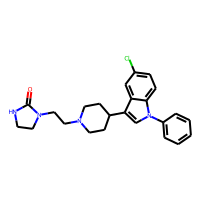
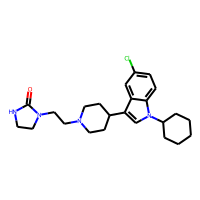
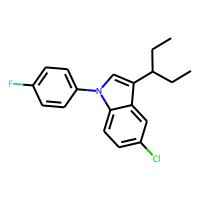
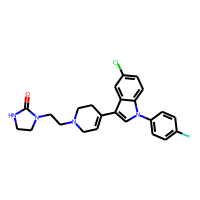
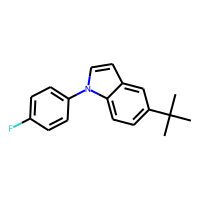
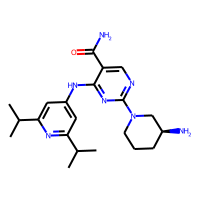
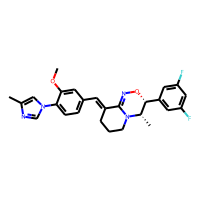
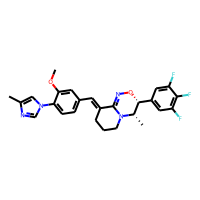
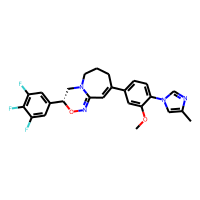
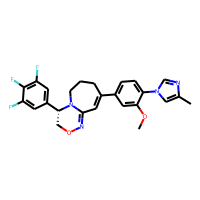

In [56]:
df

In [57]:
df.reset_index(drop=True, inplace=True)

In [58]:
PandasTools.WriteSDF(df, 'herg_smaller_right.sdf', molColName='ROMol', properties=list(df.columns))

In [59]:
df_k = df.copy(deep = False)

In [60]:
def class_str(df):
    class_str =[]
    for i in df['class']:
        if i == 1:
            class_str.append("active")
        else :
            class_str.append("inactive")
    df.drop(["class"], axis=1, inplace=True)
    df['class'] = class_str
    return df

,canonical_smiles,molecule_chembl_id,molecule_pref_name,standard_relation,standard_type,standard_units,units,value,MW,value_nM,pIC50,ROMol,class
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccccc3)c3ccc(Cl)cc23)CC1,CHEMBL443476,NaN,=,IC50,nM,nM,88.0,422.960,88.0,7.055517,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",active
1,O=C1NCCN1CCN1CCC(c2cn(C3CCCCC3)c3ccc(Cl)cc23)CC1,CHEMBL53661,NaN,=,IC50,nM,nM,137.0,429.008,137.0,6.863279,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",active
2,CCC(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12,CHEMBL299390,NaN,=,IC50,nM,nM,1480.0,315.819,1480.0,5.829738,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",active
3,O=C1NCCN1CCN1CC=C(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc23)CC1,CHEMBL12186,NaN,=,IC50,nM,nM,10.0,438.934,10.0,8.000000,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",active
4,CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1,CHEMBL299590,NaN,>,IC50,nM,nM,10000.0,267.347,10000.0,5.000000,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(C(C)C)n1,CHEMBL4635883,NaN,=,IC50,nM,uM,3.7,397.527,3700.0,5.431798,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",active
7437,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C@@H]3C)ccc1-n1cnc(C)c1,CHEMBL4643105,NaN,=,IC50,nM,nM,2007.0,464.516,2007.0,5.697453,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",active
7438,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2)[C@@H]3C)ccc1-n1cnc(C)c1,CHEMBL4634921,NaN,=,IC50,nM,nM,1607.0,482.506,1607.0,5.793984,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",active
7439,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC2)ccc1-n1cnc(C)c1,CHEMBL4634696,NaN,=,IC50,nM,nM,3352.0,468.479,3352.0,5.474696,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",active

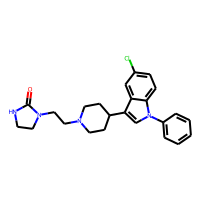
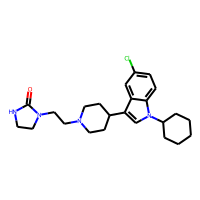
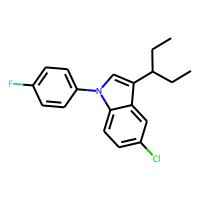
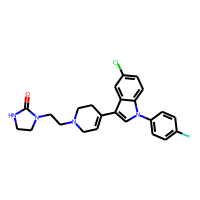
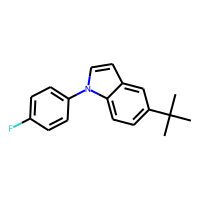
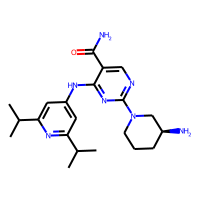
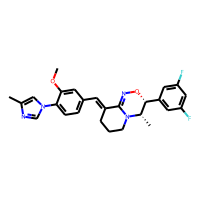
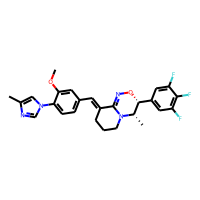
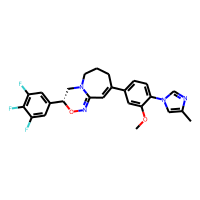
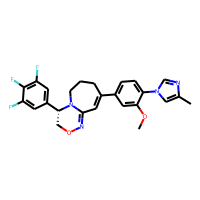

In [61]:
df_k= class_str(df_k)
df_k

In [62]:
df_k = df_k.rename(columns={"class": "activity"})

In [64]:
PandasTools.WriteSDF(df_k, 'herg_KNIME.sdf', molColName='ROMol', properties=list(df_k.columns))

In [65]:
df.drop(["ROMol"], axis=1, inplace=True)

In [66]:
df.to_csv("herg_out_smaller_right.csv", encoding='utf-8', index=False)

Также сохраним данные в smi

In [67]:
df1 = df["canonical_smiles"]
df1.to_csv("herg_for_molprop_3.smi", sep = ",", encoding='utf-8', index=False)

# Вывод:
Была проведена предобработка и фильтрация соединений по этапам: 


In [68]:
tabledata = [[1, "Скачивание всех активностей в IC50", 13200],
            [2, "Исключение активностей агонистов", 11372],
            [3, "Исключение всех типов assay за исключением Binding type", 11043],
            [4, "Исключение активностей по отношению к мутантным формам hERG", 11024],
            [5, "Исключение дубликатов (по ChEMBL_ID) и удаление строк с путыми значениями в колонках units, standard_type, value", 8093],
            [6, "Приведение всех значений IC50 к одним единицам измерения (nM)", 8093],
            [7, "Проставление меток класса (граница IC50 = 10 мкМ)", 8093],
            [8, "Исключение соединений с пропущенными или неопределенными значениями в realtion", 7999],
            [9, "Расчет pIC50", 7999],
            [10, "Стандартизация RDkit", 7999],
            [11, "Исключение солевых форм", 7737],
            [12, "Исключение известных лекарств для формирования тестовой выборки", 7441]
            ]

In [69]:
pd.set_option('max_colwidth', None)
pd.DataFrame(tabledata, columns=["№","Действие", "Число соединений"])

,№,Действие,Число соединений
0,1,Скачивание всех активностей в IC50,13200
1,2,Исключение активностей агонистов,11372
2,3,Исключение всех типов assay за исключением Binding type,11043
3,4,Исключение активностей по отношению к мутантным формам hERG,11024
4,5,"Исключение дубликатов (по ChEMBL_ID) и удаление строк с путыми значениями в колонках units, standard_type, value",8093
5,6,Приведение всех значений IC50 к одним единицам измерения (nM),8093
6,7,Проставление меток класса (граница IC50 = 10 мкМ),8093
7,8,Исключение соединений с пропущенными или неопределенными значениями в realtion,7999
8,9,Расчет pIC50,7999
9,10,Стандартизация RDkit,7999
